---
<font size="5"><div class="alert alert-info">
Chetraj Pandey | Assignment One | Advanced Topics in Deep Learning
</div></font>

---

In [ ]:
#Necessary Imports
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
from matplotlib.pyplot import figure
from torch.utils.data import DataLoader

In [ ]:
# Random Seeds for Reproducibility
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(40)

---
<font size="5"><div class="alert alert-info">
MNIST Dataset In Pytorch
Data Download, 0-1 Normalization,  and Dataset Loader
</div></font>

---

In [ ]:
#Dataset MNIST
#No need of normalizing from 0-1 because pytorch does that inherently here

#Train_Set with 60k samples
train_set = datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)

#Test_Set with 10k samples
test_set = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=True)

print('Total Instances in Train Set: ', len(train_set), '\nTotal Instances in Test Set: ', len(test_set))


# Dataloader -- Just an efficient way to load the dataset using pytorch is to use the dataloader
batch_size=64
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

# Verifying Zero-one normalization among 3 of the batches
for batch_idx, (data, _) in enumerate(train_loader):
    print('Max: ', data.max(), 'Min: ', data.min())
    if batch_idx==2:
        break

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Total Instances in Train Set:  60000 
Total Instances in Test Set:  10000
Max:  tensor(1.) Min:  tensor(0.)
Max:  tensor(1.) Min:  tensor(0.)
Max:  tensor(1.) Min:  tensor(0.)


---
<font size="5"><div class="alert alert-info">
Variational Autoencoder (VAE) Network Definition
</div></font>


In [ ]:
class EncoderNetwork(nn.Module):
    def __init__(self):
        super(EncoderNetwork, self).__init__()
        
        self.fc1 = nn.Linear(784, 512)
        self.fc2_mu = nn.Linear(512, 2)
        self.fc2_log_sigma_square = nn.Linear(512,2)
    
    #reparameterization trick to sample z as input to the decoder.
    def reparameterization_trick(self, mu, log_sigma_square):
        std_dev = torch.exp(0.5*log_sigma_square)
        #epsilon is a random sample from Gaussian N(0,I)
        epsilon = torch.randn_like(std_dev)
        return epsilon*(std_dev)+(mu)
    
    def forward(self, x):
        h = F.relu(self.fc1(x.view(-1, 784)))
        mu, log_sigma_square = self.fc2_mu(h), self.fc2_log_sigma_square(h)
        z = self.reparameterization_trick(mu, log_sigma_square)
        return z, mu, log_sigma_square
        
class DecoderNetwork(nn.Module):
    def __init__(self):
        super(DecoderNetwork, self).__init__()
        
        self.fc1 = nn.Linear(2, 512)
        self.fc2 = nn.Linear(512, 784)
        
    def forward(self,z):
        h = F.relu(self.fc1(z))
        return torch.sigmoid(self.fc2(h))
    
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.encoder = EncoderNetwork()
        self.decoder = DecoderNetwork()
        
    def forward(self, x):
        z, mu, log_sigma_square = self.encoder(x)
        return self.decoder(z), mu, log_sigma_square

---
<font size="5"><div class="alert alert-info">
Comp. Resoc. (CPU or GPU -- I used CPU), Load Model, Optimizer, and Loss Function
</div></font>

---

In [ ]:
#Computational Node -- Either CPU or GPU
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.backends.cudnn.benchmark = True
print('Device:', device)

#Load model to memory
model = VAE().to(device)

#Define Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-2)

# Defining Total Loss = reconstruction loss + KL divergence loss
def loss_function(x_hat, x, mu, log_sig_sq):
    BCE = F.binary_cross_entropy(x_hat, x.view(-1, 784), reduction='sum')
    KLD = -(1/2) * torch.sum(1 + log_sig_sq - mu.pow(2) - log_sig_sq.exp())
    return BCE + KLD

Device: cpu


---
<font size="5"><div class="alert alert-info">
Training and Testing Model - Only 50 epochs due to high computational time in CPU
</div></font>

---

In [ ]:
def train_model():
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        x_hat, mu, log_sig_sq = model(data)
        loss = loss_function(x_hat, data, mu, log_sig_sq)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()       
    train_loss /= len(train_loader.dataset)
    return train_loss

def test_model():
    model.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            x_hat, mu, log_sig_sq = model(data)
            test_loss += loss_function(x_hat, data, mu, log_sig_sq).item()
    test_loss /= len(test_loader.dataset)
    return test_loss


loss_values = []
for epoch in range(1, 51):
    tr_loss= train_model()
    te_loss = test_model()
    loss_values.append([tr_loss, te_loss])
    print('Epoch: ', epoch, '|' 'Training loss: {:.4f} | Testing Loss: {:.4f}'.format(tr_loss, te_loss))

Epoch:  1 |Training loss: 169.9890 | Testing Loss: 163.1861
Epoch:  2 |Training loss: 160.7978 | Testing Loss: 158.8507
Epoch:  3 |Training loss: 158.9206 | Testing Loss: 158.7789
Epoch:  4 |Training loss: 157.6701 | Testing Loss: 157.9058
Epoch:  5 |Training loss: 156.7805 | Testing Loss: 159.3747
Epoch:  6 |Training loss: 156.1286 | Testing Loss: 156.3214
Epoch:  7 |Training loss: 155.6682 | Testing Loss: 154.7888
Epoch:  8 |Training loss: 155.1480 | Testing Loss: 155.9513
Epoch:  9 |Training loss: 154.8766 | Testing Loss: 155.1893
Epoch:  10 |Training loss: 154.6774 | Testing Loss: 157.7765
Epoch:  11 |Training loss: 154.3790 | Testing Loss: 154.9869
Epoch:  12 |Training loss: 154.2259 | Testing Loss: 154.6427
Epoch:  13 |Training loss: 154.2492 | Testing Loss: 153.7891
Epoch:  14 |Training loss: 153.8909 | Testing Loss: 154.5559
Epoch:  15 |Training loss: 153.9166 | Testing Loss: 154.4114
Epoch:  16 |Training loss: 153.7724 | Testing Loss: 154.6683
Epoch:  17 |Training loss: 153.72

---
<font size="5"><div class="alert alert-info">
Q1) Training curves (loss vs epochs)
</div></font>

---

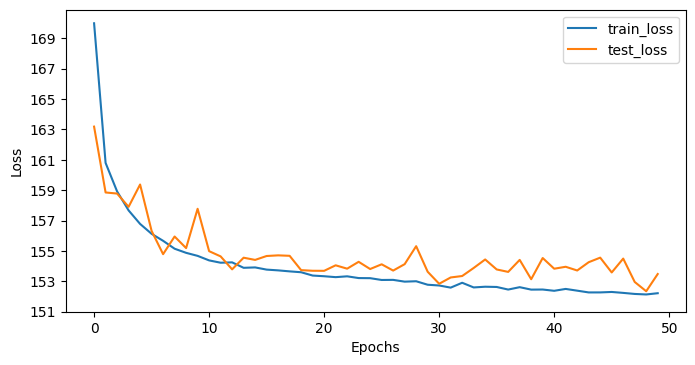

In [ ]:
# Training curves (loss vs epochs)
figure(figsize=(8, 4), dpi=100)
def plot_results(train_loss, test_loss):
    plt.plot(train_loss, label='train_loss')
    plt.plot(test_loss, label='test_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yticks(np.arange(151, 170, 2))
    plt.legend()
    plt.show()
    
plot_results([item[0] for item in loss_values], [item[1] for item in loss_values]) 

---
<font size="5"><div class="alert alert-info">
Q2) 2D-scatter plot of the z values corresponding to a random subset of 5000 MNIST input images from Test Set
</div></font>

---

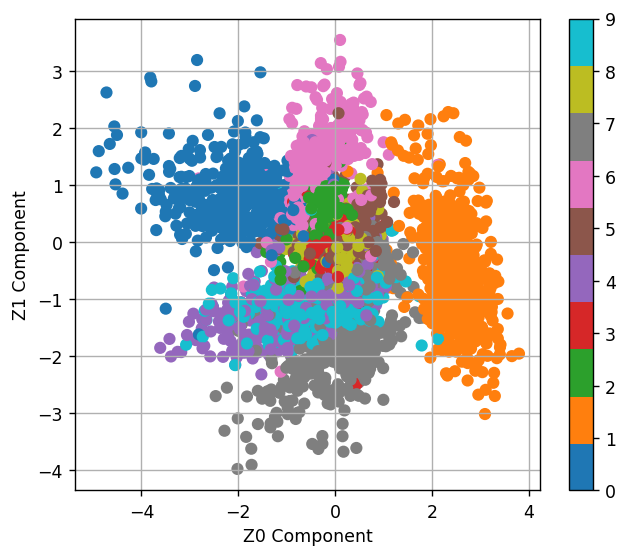

In [ ]:
#2D-scatter plot of the z values corresponding to a random subset of 5000 MNIST input images
figure(figsize=(6, 5), dpi=125)
def z_val_scatter():
    
    test_loader = torch.utils.data.DataLoader(dataset=test_set,  batch_size=5000, shuffle=False)
    x_set, y_set = next(iter(test_loader))
    x_set = x_set.reshape(-1, 28*28)
    z_set = model.encoder(x_set)[0].detach().numpy()
    color = y_set
    plt.scatter(z_set[:, 0], z_set[:, 1], c=color, cmap='tab10')
    plt.xlabel('Z0 Component')
    plt.ylabel('Z1 Component')
    plt.colorbar()
    plt.grid()
    return y_set, z_set

# Will use y_set and z_set for q3 and q4
y_set, z_set = z_val_scatter()

---
<font size="5"><div class="alert alert-info">
Q3) A grid plot of 15x15 generated images which are the outputs of the decoder
generated for the complete range of z values across the two components of z.
</div></font>

---

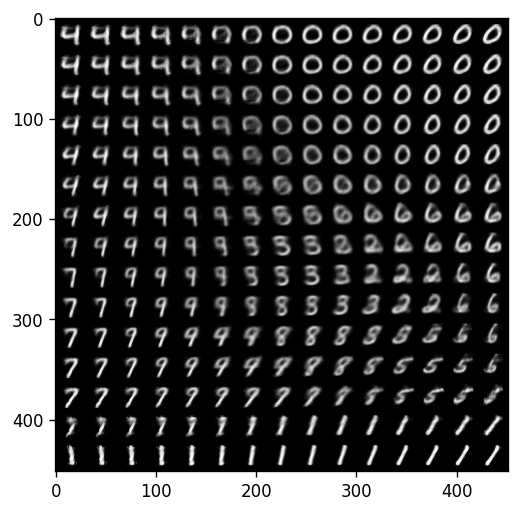

In [ ]:
#A grid plot of 15x15 generated images which are the outputs of the decoder
# generated for the complete range of z values across the two components of z.


figure(figsize=(5, 5), dpi=120)
def show_images(images, nrow):
    images = torchvision.utils.make_grid(images, nrow=nrow)
    plt.imshow(images[0], cmap='gray')
    plt.show()

with torch.no_grad():
    #Generating 15*15 images for the complete range of z values across two components of z
    z = z_set.copy()
    
    #Clamped values in both ends by TWO Unit--because max and min generated 
    #very wierd shapes (for complete range +2 and -2 can be removed while defining range below)
    z_0 = np.linspace(z[:,0].min()+2, z[:,0].max()-2, num=15)
    z_1 = np.linspace(z[:,1].min()+2, z[:,1].max()-2, num=15)
    a = pd.DataFrame({'x':np.repeat(z_0,z_1.shape[0]),
                  'y':np.tile(z_1,z_0.shape[0])}).values
    gen = torch.FloatTensor(a)
    sample_images = model.decoder(torch.FloatTensor(gen))
    sample_images_ = sample_images.view(len(gen), 1, 28,28)
    show_images(sample_images_, 15)


---
<font size="5"><div class="alert alert-info">
Q4) Create a grid of generated images where each row/column corresponds to
varying images for one digit. Identify the z values that will generate the digit
and vary the z to generate 5 samples for each digit.
</div></font>

---

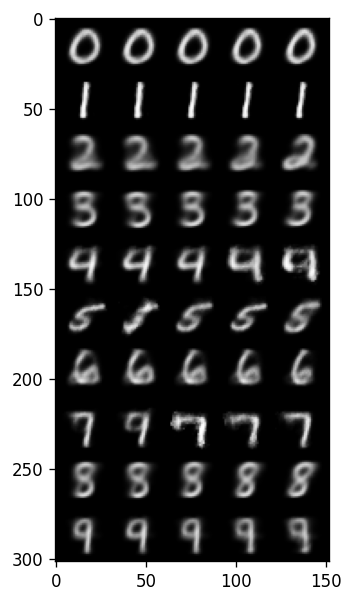

In [ ]:
# Basic Idea = Get the mean and std of z0 and z1 for each class and generate [z0,z1] tuple from normal distribution
# given the mean and std

a = np.empty(shape=(1, 2), dtype=float)
for i in range(0,10):
    index = (y_set == i).nonzero(as_tuple=True)[0]
    index  = index.detach().numpy()
    z = z_set[index]
    # generate z from normal dist with a mean of of component for each class
    z_0 = np.random.normal(loc=np.mean(z[:,0]), scale=np.std(z[:,0]/10), size=5) # too high deviation so reduced
    z_1 = np.random.normal(loc=np.mean(z[:,1]), scale=np.std(z[:,1]/10), size=5)
    
    #Manual Hit-and-trial for 4, 5, and 7 based on above graph in Q2 (Gave me a hard time)
    #z-component varying for 4, 5, and 7
    if i==4:
        z_0 = z_0 + [-0.95, -0.85, -0.65, -2, -3] 
        z_1 = z_1 +  [-0.65, -0.75, -0.65, -0.30, -0.25]
        
    elif i==5:
        z_0 = z_0 + [1, 1.2, 0.7, 0.9, 0.6] 
        z_1 = z_1 +  [1., 1.2, 0.8, 0.9, 0.7]
    
    elif i==7:
    # Varying z components other classes
        z_0 = z_0 + [-0.35, -0.9, -3, -1.70, -0.65] 
        z_1 = z_1 +  [-0.35, -0.45, -2.5, -1.80, -0.95]  
        
    else:
        z_0 = z_0 + [0., -0.10, 0.05, 0.15, 0.25] 
        z_1 = z_1 +  [0.0, -0.10, 0.05, 0.15, 0.25] 
    combined = np.vstack((z_0, z_1)).T
    a = torch.Tensor(np.concatenate((a,combined), axis=0))

figure(figsize=(5, 6), dpi=120)

with torch.no_grad():
    sample_images = model.decoder(torch.Tensor(a[1:]).to(device))
    sample_images_ = sample_images.view(len(a[1:]), 1, 28,28)
    show_images(sample_images_, 5)

---
<font size="5"><div class="alert alert-info">
    [View in Google Colab](url_here)
</div></font>
<font size="5"><div class="alert alert-info">
    ************************************ End of Notebook ************************************
</div></font>